In [9]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn import metrics

# make the plot pretty
plt.style.use('ggplot')

In [70]:
def plot_roc_curve(ax, fpr, tpr, auc, label=None):
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.plot([0,1], [0,1], 'k--')
    ax.legend([f"{label} AUC = {auc:.4f}"], fontsize=16)

In [2]:
def load_images_and_labels():
    '''
    Loads all images from directory 'images' with targets as the folder
    name. Images were scrapped from google.
    inputs
    ------
    None

    returns
    -------
    images: numpy array of images
    labels: numpy array of labels
    '''
    images = []
    labels = []
    # get list of images from the directory
    image_paths = list(paths.list_images('../images/'))
    
    # loop over the image_paths
    for image_path in image_paths:
        label = image_path.split(os.path.sep)[-2]
        img = load_img(image_path, target_size=(224,224))
        img = img_to_array(img)
        img = preprocess_input(img)

        # add the image and label to the respective lists
        images.append(img)
        labels.append(label)

    # convert the images and labels to numpy arrays
    images = np.array(images, dtype="float32")
    labels = np.array(labels)

    return images, labels

In [79]:
def train_CNN(images, labels, epochs, learning_rate, bs):
    '''
    Train the CNN using transfer learning and images from 
    load_images_and_labels().
    '''

    # turn labels into binary labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)

    # split data using 20% as testing data
    X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                        test_size=0.20, 
                                                        stratify=labels, 
                                                        random_state=17)

    # transformations
    train_transformations = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        zoom_range=0.10,
        shear_range=0.10,
        horizontal_flip=True,
        fill_mode="nearest" # constant, nearest, reflect, or wrap
    )

    # load the MobileNetV2 network, ensuring the head FC layer sets are 
    # left off
    base_model = Xception(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(224,224,3)))
    base_type = 'Xception'

    # build model head
    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7,7))(head_model)
    head_model = Flatten(name='flatten')(head_model)
    head_model = Dense(128, activation='relu')(head_model)
    head_model = Dropout(0.50)(head_model)
    head_model = Dense(2, activation="softmax")(head_model)

    # place the head FC model on top of the base model (this will become 
    # the actual model we will train)
    model = Model(inputs=base_model.input, outputs=head_model)

    for layer in base_model.layers:
        layer.trainable = False 

    # initalize adam optimizer
    opt = Adam(lr = learning_rate, decay = learning_rate / epochs)

    # compile and fit model
    model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=["accuracy"])
    history = model.fit(
        train_transformations.flow(X_train, y_train, batch_size=bs),
        steps_per_epoch=len(X_train) // bs,
        validation_data = (X_test, y_test),
        validation_steps = len(X_test) // bs,
        epochs=epochs
    )
    
    probabilities = model.predict(X_test, batch_size=bs)

    # get predictions and generate confusion matrix data
#     y_pred = model.predict(X_test, batch_size=bs)
#     con_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    # show a nicely formatted classification report
    # print(classification_report(y_test.argmax(axis=1), y_pred,
    #     target_names=lb.classes_))

    # plot the loss and accuracy
#     fig, ax = plt.subplots()
#     ax.plot(np.arange(0,epochs), history.history["accuracy"], label="Training Accuracy")
#     ax.plot(np.arange(0,epochs), history.history["val_accuracy"], label="Validation Accuracy")
#     ax.set_xlabel("Epoch #", fontsize=12)
#     ax.set_ylabel("Loss/Accuracy", fontsize=12)
#     ax.set_title('Model Accuracy with {}'.format(base_type), fontsize=14)
#     ax.legend()
#     plt.savefig('../plots/plot_{}_{}_{}.png'.format(epochs, bs, base_type))

    # return the model
    return y_test.argmax(axis=1), probabilities[:, 1]

In [63]:
# images, labels = load_images_and_labels()

In [75]:
epochs = 20
learning_rate = 0.001
batch_size = 32

In [76]:
y_test_mobile, probs_mobile = train_CNN(images, labels, epochs, 
                        learning_rate, batch_size)

Epoch 1/20
16/16 [==============================] - 10s 611ms/step - loss: 0.5336 - accuracy: 0.7692 - val_loss: 0.2161 - val_accuracy: 0.8963
Epoch 2/20
16/16 [==============================] - 9s 561ms/step - loss: 0.2379 - accuracy: 0.9093 - val_loss: 0.1463 - val_accuracy: 0.9407
Epoch 3/20
16/16 [==============================] - 9s 564ms/step - loss: 0.1750 - accuracy: 0.9369 - val_loss: 0.1224 - val_accuracy: 0.9556
Epoch 4/20
16/16 [==============================] - 9s 559ms/step - loss: 0.1209 - accuracy: 0.9507 - val_loss: 0.0967 - val_accuracy: 0.9704
Epoch 5/20
16/16 [==============================] - 9s 557ms/step - loss: 0.1047 - accuracy: 0.9546 - val_loss: 0.1147 - val_accuracy: 0.9630
Epoch 6/20
16/16 [==============================] - 9s 566ms/step - loss: 0.1226 - accuracy: 0.9586 - val_loss: 0.0774 - val_accuracy: 0.9630
Epoch 7/20
16/16 [==============================] - 9s 560ms/step - loss: 0.0869 - accuracy: 0.9625 - val_loss: 0.1599 - val_accuracy: 0.9556
Epoch

In [78]:
y_test_res, probs_res = train_CNN(images, labels, epochs, 
                        learning_rate, batch_size)

Epoch 1/20
16/16 [==============================] - 29s 2s/step - loss: 0.8022 - accuracy: 0.5266 - val_loss: 0.6651 - val_accuracy: 0.5333
Epoch 2/20
16/16 [==============================] - 28s 2s/step - loss: 0.7090 - accuracy: 0.5700 - val_loss: 0.6324 - val_accuracy: 0.6741
Epoch 3/20
16/16 [==============================] - 28s 2s/step - loss: 0.6479 - accuracy: 0.6095 - val_loss: 0.6369 - val_accuracy: 0.6148
Epoch 4/20
16/16 [==============================] - 28s 2s/step - loss: 0.6300 - accuracy: 0.6391 - val_loss: 0.6135 - val_accuracy: 0.6519
Epoch 5/20
16/16 [==============================] - 28s 2s/step - loss: 0.6424 - accuracy: 0.5957 - val_loss: 0.6014 - val_accuracy: 0.6815
Epoch 6/20
16/16 [==============================] - 28s 2s/step - loss: 0.6203 - accuracy: 0.6410 - val_loss: 0.6064 - val_accuracy: 0.6741
Epoch 7/20
16/16 [==============================] - 28s 2s/step - loss: 0.6114 - accuracy: 0.6371 - val_loss: 0.6012 - val_accuracy: 0.6815
Epoch 8/20
16/16 [==

In [80]:
y_test_x, probs_x = train_CNN(images, labels, epochs, 
                        learning_rate, batch_size)

Epoch 1/20
16/16 [==============================] - 37s 2s/step - loss: 0.2631 - accuracy: 0.8895 - val_loss: 0.0839 - val_accuracy: 0.9852
Epoch 2/20
16/16 [==============================] - 36s 2s/step - loss: 0.1834 - accuracy: 0.9231 - val_loss: 0.0682 - val_accuracy: 0.9778
Epoch 3/20
16/16 [==============================] - 36s 2s/step - loss: 0.1900 - accuracy: 0.9211 - val_loss: 0.0705 - val_accuracy: 0.9630
Epoch 4/20
16/16 [==============================] - 37s 2s/step - loss: 0.1167 - accuracy: 0.9629 - val_loss: 0.0603 - val_accuracy: 0.9704
Epoch 5/20
16/16 [==============================] - 36s 2s/step - loss: 0.1171 - accuracy: 0.9527 - val_loss: 0.0570 - val_accuracy: 0.9778
Epoch 6/20
16/16 [==============================] - 36s 2s/step - loss: 0.1132 - accuracy: 0.9527 - val_loss: 0.0528 - val_accuracy: 0.9926
Epoch 7/20
16/16 [==============================] - 36s 2s/step - loss: 0.0866 - accuracy: 0.9665 - val_loss: 0.0654 - val_accuracy: 0.9778
Epoch 8/20
16/16 [==

In [90]:
def plot_roc_curve(ax, fpr, tpr, auc, label=None):
    ax.plot(fpr, tpr, linewidth=2, label=f"{label} AUC = {auc:.4f}")
    ax.plot([0,1], [0,1], 'k--')

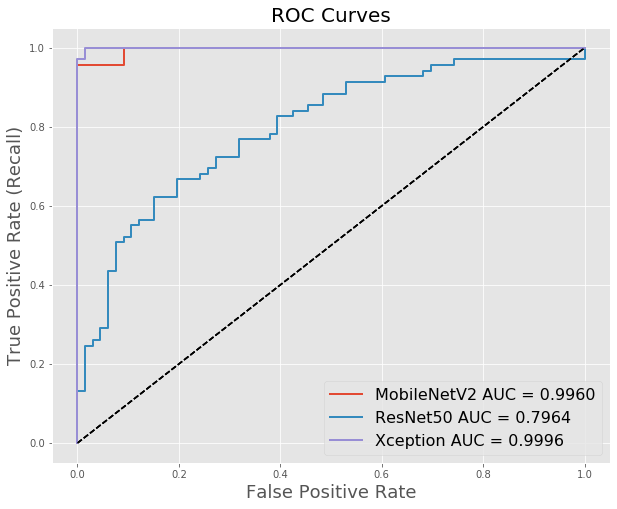

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))
# mobile
fpr_m, tpr_m, thresholds_m = metrics.roc_curve(y_test_mobile, probs_mobile)
auc_score_mobile = metrics.roc_auc_score(y_test_mobile, probs_mobile)
plot_roc_curve(ax, fpr_m, tpr_m, auc_score_mobile, 'MobileNetV2')
# resnet50
fpr_r, tpr_r, thresholds_r = metrics.roc_curve(y_test_res, probs_res)
auc_score_res = metrics.roc_auc_score(y_test_res, probs_res)
plot_roc_curve(ax, fpr_r, tpr_r, auc_score_res, 'ResNet50')
# xception
fpr_x, tpr_x, thresholds_x = metrics.roc_curve(y_test_x, probs_x)
auc_score_x = metrics.roc_auc_score(y_test_x, probs_x)
plot_roc_curve(ax, fpr_x, tpr_x, auc_score_x, 'Xception')


ax.set_title('ROC Curves', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=18)
ax.legend(fontsize=16)
plt.savefig('../plots/roc_curve.png')